<a href="https://colab.research.google.com/github/dhanaKankanala/Music_Generation/blob/main/dhana_working_Copy_of_GRU_60_Music_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

pip install --upgrade music21

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 22.7 MB/s eta 0:00:00
  Attempting uninstall: music21
    Found existing installation: music21 9.3.0
    Uninstalling music21-9.3.0:
      Successfully uninstalled music21-9.3.0


<ipython-input-2-f0d9a0b77165>:26: RuntimeWarning: divide by zero encountered in divide
  y_values = -(theta[0] * x_values) / theta[1]


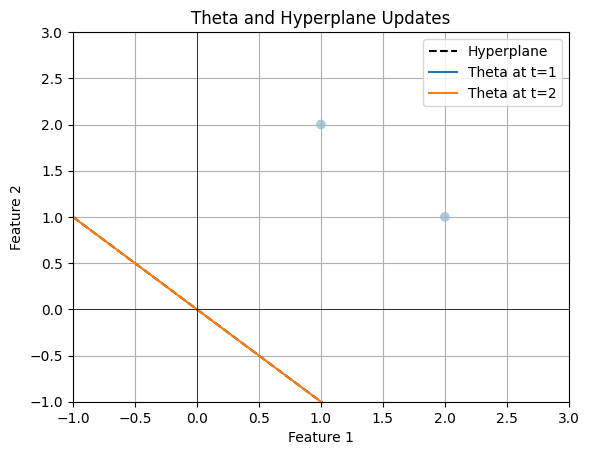

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Data points and labels
data_points = np.array([[1, 2], [2, 1]])
labels = np.array([-1, -1])

# Initial theta
theta = np.array([2, 2])

# Plot the data points
plt.scatter(data_points[:, 0], data_points[:, 1], c=labels, cmap=plt.cm.Paired, marker='o')

# Plot the hyperplane defined by theta
x_values = np.linspace(-1, 3, 100)
y_values = -(theta[0] * x_values) / theta[1]  # hyperplane equation: theta0 * x + theta1 * y = 0
plt.plot(x_values, y_values, 'k--', label='Hyperplane')

# Update theta at each step and plot the new hyperplane
for t in range(data_points.shape[0]):
    x = data_points[t]
    y = labels[t]
    hypothesis = np.dot(theta, x)
    if y * hypothesis <= 0:
        theta += y * x
        y_values = -(theta[0] * x_values) / theta[1]
        plt.plot(x_values, y_values, label=f'Theta at t={t+1}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.title('Theta and Hyperplane Updates')
plt.show()

In [3]:
#DataFlair Automatic Music Generation Project
#load all the libraries
from music21 import *
import glob
import os
from tqdm import tqdm
import numpy as np
import random
from tensorflow.keras.layers import LSTM,Dense,Input,Dropout, GRU,BatchNormalization
from tensorflow.keras.models import Sequential,Model,load_model
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [7]:
from google.colab import files
uploaded = files.upload()
#Upload the raw zip datafile(musicgenerationdata.zip)

Saving musicgenerationdata.zip to musicgenerationdata (1).zip


In [9]:
import zipfile
import os

zip_path = "/content/midi_data/musicgenerationdata.zip"  # Update with your uploaded file's name
extract_path = "/content/midi_data"  # Folder to extract files

# Extract ZIP file
os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Files extracted to:", extract_path)


Files extracted to: /content/midi_data


In [10]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
DATA_DIR = '/content/midi_data/musicgenerationdata'

In [12]:
def read_files(file):
  notes=[]
  notes_to_parse=None
  #parse the midi file
  midi=converter.parse(file)
  #seperate all instruments from the file
  instrmt=instrument.partitionByInstrument(midi)

  for part in instrmt.parts:
  #fetch data only of Piano instrument
    if 'Piano' in str(part):
      notes_to_parse=part.recurse()

    #iterate over all the parts of sub stream elements
    #check if element's type is Note or chord
    #if it is chord split them into notes
    for element in notes_to_parse:
      if type(element)==note.Note:
        notes.append(str(element.pitch))
      elif type(element)==chord.Chord:
        notes.append('.'.join(f"{note.Note(n).pitch.pitchClass}{note.Note(n).octave}" for n in element.normalOrder))
      elif isinstance(element, note.Rest):
        notes.append('Rest')

  #return the list of notes
  return notes

#retrieve paths recursively from inside the directories/files
file_path=["schubert","chopin","bach","balakir","beeth","borodin","brahms","burgm","debussy","granados","grieg","haydn","liszt","mendelssohn","mozart","muss","schumann","tschai"]
for file in range(len(file_path)):
  print("files",os.path.join(DATA_DIR,'All Midi Files/'+file_path[file]+'/*.mid'))
  all_files=glob.glob(os.path.join(DATA_DIR,'All Midi Files/'+file_path[file]+'/*.mid'),recursive=True)
# all_files = glob.glob(os.path.join(DATA_DIR, '**', '*.mid'), recursive=True) # Use this line if you want to train on entire directory

#reading each midi file
notes_array = [read_files(i) for i in tqdm(all_files,position=0,leave=True)]
# notes_array = np.array([np.array(seq, dtype=object) for seq in notes_array], dtype=object)

files /content/midi_data/musicgenerationdata/All Midi Files/schubert/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/chopin/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/bach/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/balakir/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/beeth/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/borodin/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/brahms/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/burgm/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/debussy/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/granados/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/grieg/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/haydn/*.mid
files /content/midi_data/musicgenerationdata/All Midi Files/liszt/*.mid
files /content/midi_data/musicgenerationdata/All Mi

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2004 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
 58%|█████▊    | 7/12 [00:17<00:11,  2.24s/it]/usr/local/lib/python3.11/dist-packages/music21/midi/translate.py:874: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=4, channel=None, data=b'Copyright \xa9 2000 by Bernd Kr\xfcger'>; getting generic Instrument
  warnings.warn(
100%|██████████| 12/12 [00:31<00:00,  2.63s/it]


In [13]:
#unique notes
# notess = sum(notes_array,[])
notess = [note for seq in notes_array for note in seq]
unique_notes = list(set(notess))
print("Unique Notes:",len(unique_notes))

#notes with their frequency
freq=dict(map(lambda x: (x,notess.count(x)),unique_notes))

#get the threshold frequency
for i in range(30,100,20):
  print(i,":",len(list(filter(lambda x:x[1]>=i,freq.items()))))

Unique Notes: 244
30 : 96
50 : 65
70 : 56
90 : 51


In [14]:
#filter notes greater than threshold i.e. 50
freq_notes=dict(filter(lambda x:x[1]>=50,freq.items()))

#create new notes using the frequent notes
new_notes=[[i for i in j if i in freq_notes] for j in notes_array]

In [15]:
#dictionary having key as note index and value as note
ind2note=dict(enumerate(freq_notes))

#dictionary having key as note and value as note index
note2ind=dict(map(reversed,ind2note.items()))

In [16]:
#timestep
timesteps=50

#store values of input and output
x=[] ; y=[]

for i in new_notes:
 for j in range(0,len(i)-timesteps):
  #input will be the current index + timestep
  #output will be the next index after timestep
  inp=i[j:j+timesteps] ; out=i[j+timesteps]

  #append the index value of respective notes
  x.append(list(map(lambda x:note2ind[x],inp)))
  y.append(note2ind[out])

x = [seq for seq in x if len(seq) == timesteps]  # Remove sequences that are too short
y = [y[i] for i in range(len(y)) if len(x[i]) == timesteps]  # Ensure y aligns

x_new = np.array(x)
y_new = np.array(y)

In [18]:
#reshape input and output for the model
x_new = np.reshape(x_new,(len(x_new),timesteps,1))
y_new = np.reshape(y_new,(-1,1))

#split the input and value into training and testing sets
#80% for training and 20% for testing sets
x_train,x_test,y_train,y_test = train_test_split(x_new,y_new,test_size=0.3,random_state=36)

In [19]:

#create the model
model = Sequential()
# Create two stacked GRU layers with the latent dimension of 256
model.add(LSTM(256, return_sequences=True, input_shape=(x_new.shape[1], x_new.shape[2])))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(GRU(512, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(GRU(256))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu',kernel_regularizer=l2(0.001)))

#fully connected layer for the output with softmax activation
model.add(Dense(len(note2ind),activation='softmax'))
model.summary()



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 256)             │         264,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 50, 512)             │       1,182,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 256)                 │         591,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 65)                  │          16,705 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,124,865 (8.11 MB)

 Trainable params: 2,122,817 (8.10 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [20]:
from keras.optimizers import Adamax

# compile the model using Adam optimizer
optimizer = Adamax(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,metrics=['accuracy'])
print(x_train.shape,y_train.shape,"shapes",x_test.shape,y_test.shape)
#train the model on training sets and validate on testing sets
model.fit(
 x_train,y_train,
 batch_size=128,epochs=80,
 validation_data=(x_test,y_test))

(9723, 50, 1) (9723, 1) shapes (4168, 50, 1) (4168, 1)
Epoch 1/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.2488 - loss: 3.9965 - val_accuracy: 0.3244 - val_loss: 3.6425
Epoch 2/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.3221 - loss: 3.5056 - val_accuracy: 0.3249 - val_loss: 3.6607
Epoch 3/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.3197 - loss: 3.4257 - val_accuracy: 0.3251 - val_loss: 3.6246
Epoch 4/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.3335 - loss: 3.3147 - val_accuracy: 0.3201 - val_loss: 3.6071
Epoch 5/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.3366 - loss: 3.2224 - val_accuracy: 0.3203 - val_loss: 3.4865
Epoch 6/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.3458 - loss: 3.1357 - val_accuracy: 0.3285 - val_loss: 3.3346
Epoch 7/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.3402 - loss: 3.0804 - val_accuracy: 0.3316 - val_loss: 3.2861
Epoch 8/80
76/76 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - acc

In [27]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc} Test Loss: {test_loss}")


131/131 ━━━━━━━━━━━━━━━━━━━━ 38s 269ms/step - accuracy: 0.5735 - loss: 2.7969
Test Accuracy: 0.5626199841499329 Test Loss: 2.8662283420562744
131/131 ━━━━━━━━━━━━━━━━━━━━ 27s 208ms/step - accuracy: 0.5735 - loss: 2.7969
Test Accuracy: 0.5626199841499329 Test Loss: 2.8662283420562744


In [29]:
#save the model for predictions
model.save("s2s1.keras")

In [ ]:
# #load the model
# model = load_model("s2s1")
# #generate random index
# index = np.random.randint(0,len(x_test)-1)
# #get the data of generated index from x_test
# music_pattern = x_test[index]
 # out_pred=[] #it will store predicted notes

# #iterate till 200 note is generated
# for i in range(200):

#  #reshape the music pattern
#  music_pattern = music_pattern.reshape(1,len(music_pattern),1)
#  # Get the predicted output probabilities from the model
#  pred_probs = model.predict(music_pattern)[0]
#  # Select the top 7 probabilities and standardize them
#  top_indices = np.argsort(pred_probs)[-7:]
#  top_probs = pred_probs[top_indices]
#  standardized_probs = top_probs / np.sum(top_probs)
#  # Sample the next note index from the modified probability distribution
#  pred_index = np.random.choice(top_indices, p=standardized_probs)


# #  #get the maximum probability value from the predicted output
# #  pred_index = np.argmax(model.predict(music_pattern))
#  #get the note using predicted index and
#  #append to the output prediction list
#  out_pred.append(ind2note[pred_index])
#  music_pattern = np.append(music_pattern,pred_index)

#  #update the music pattern with one timestep ahead
#  music_pattern = music_pattern[1:]

# Assuming you have imported necessary libraries and loaded the model
from keras.models import load_model
import numpy as np

# Load the trained model
model = load_model("s2s1.keras")

# Generate a random index
index = np.random.randint(0, len(x_test) - 1)

# Get the corresponding sequence from x_test
music_pattern = x_test[index].reshape(1, timesteps, 1)
out_pred = []  # List to store generated notes

# Generate 200 notes
for i in range(200):
    # Predict next note probabilities
    pred_probs = model.predict(music_pattern)[0]

    # Select the top 7 probabilities
    top_indices = np.argsort(pred_probs)[-7:]
    top_probs = pred_probs[top_indices]

    # Standardize probabilities to avoid division by zero
    standardized_probs = top_probs / (np.sum(top_probs) + 1e-8)

    # Sample from the top 7 probabilities
    pred_index = np.random.choice(top_indices, p=standardized_probs)

    # Append the predicted note only if it is valid
    if pred_index in ind2note:
        out_pred.append(ind2note[pred_index])
    else:
        print(f"Warning: Skipped invalid index {pred_index}")

    # Update the music pattern (keep only the last `timesteps` values)
    music_pattern = np.append(music_pattern, pred_index)
    music_pattern = music_pattern[-timesteps:].reshape(1, timesteps, 1)  # Ensure correct shape

print("Generated Music Sequence:", out_pred)




In [30]:
# output_notes = []
# for offset,pattern in enumerate(out_pred):
#   #if pattern is a chord instance
#   if ('.' in pattern) or pattern.isdigit():
#     if pattern == 'Rest':
#       new_note = note.Rest()
#     else:
#       #split notes from the chord
#       notes_in_chord = pattern.split('.')
#       notes = []
#       for current_note in notes_in_chord:
#         i_curr_note=int(current_note)
#         #cast the current note to Note object and
#         #append the current note
#         new_note = note.Note(i_curr_note)
#         new_note.storedInstrument = instrument.Piano()
#         notes.append(new_note)

#       #cast the current note to Chord object
#       #offset will be 1 step ahead from the previous note
#       #as it will prevent notes to stack up
#       new_chord = chord.Chord(notes)
#       new_chord.offset = offset
#       output_notes.append(new_chord)

#   else:
#     #cast the pattern to Note object apply the offset and
#     #append the note
#     new_note = note.Note(pattern)
#     new_note.offset = offset
#     new_note.storedInstrument = instrument.Piano()
#     output_notes.append(new_note)

# #save the midi file
# midi_stream = stream.Stream(output_notes)
# midi_stream.write('midi', fp='pred_music4.mid')
from music21 import stream, note, chord
import copy

output_notes = []

for offset, pattern in enumerate(out_pred):
    new_note = None  # Initialize

    if pattern == 'Rest':
        new_note = note.Rest()

    elif '.' in pattern or pattern.isdigit():
        if pattern.isdigit():
            notes_in_chord = [pattern]  # Single note in chord format
        else:
            notes_in_chord = pattern.split('.')  # Split chord into notes

        notes = []
        for current_note in notes_in_chord:
            if current_note.isdigit():
                i_curr_note = int(current_note)
                temp_note = note.Note(i_curr_note)
                temp_note.storedInstrument = instrument.Piano()
                notes.append(temp_note)
            else:
                print(f"Skipping invalid note: {current_note}")  # Debugging

        if len(notes) > 1:
            new_note = chord.Chord(notes)

    else:
        try:
            new_note = note.Note(pattern)
            new_note.storedInstrument = instrument.Piano()
        except Exception as e:
            print(f"Skipping invalid pattern: {pattern} - Error: {e}")
            continue  # Skip invalid notes

    if new_note:
        new_note.offset = offset  # Set offset for timing
        output_notes.append(copy.deepcopy(new_note))  # Ensure unique object reference

# Save the MIDI file
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='pred_music4.mid')

print("MIDI file successfully created: pred_music4.mid")





Skipping invalid note: 8None
Skipping invalid note: 0None
Skipping invalid note: 3None
Skipping invalid note: 8None
Skipping invalid note: 0None
Skipping invalid note: 3None
Skipping invalid note: 8None
Skipping invalid note: 0None
Skipping invalid note: 3None
Skipping invalid note: 6None
Skipping invalid note: 11None
Skipping invalid note: 11None
Skipping invalid note: 2None
Skipping invalid note: 6None
Skipping invalid note: 11None
Skipping invalid note: 3None
Skipping invalid note: 6None
Skipping invalid note: 8None
Skipping invalid note: 0None
Skipping invalid note: 3None
Skipping invalid note: 6None
Skipping invalid note: 11None
Skipping invalid note: 6None
Skipping invalid note: 11None
Skipping invalid note: 11None
Skipping invalid note: 2None
Skipping invalid note: 6None
Skipping invalid note: 11None
Skipping invalid note: 2None
Skipping invalid note: 6None
Skipping invalid note: 8None
Skipping invalid note: 0None
Skipping invalid note: 3None
Skipping invalid note: 4None
Skippin